## RAG FROM SCRATCH 
This notebook is based on this tutorial. Codes and images are taken from this repo (https://github.com/langchain-ai/rag-from-scratch).<br /> 
Used GROQ api for llama3.1-8b model instead of OpenAI model. Also the embedding model is used from huggingface instead of OpenAI. 


![alt text](overview-rag.png)

In [3]:
! pip3 install langchain_community tiktoken langchain-openai langchainhub chromadb langchain --quiet


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [1]:
import os
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_API_KEY'] = 'YOUR_API_KEY'

In [2]:
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from langchain_core.output_parsers import StrOutputParser

load_dotenv()

True

In [3]:
key = os.getenv('GROQ_API_KEY')
parser = StrOutputParser()

## INDEXING


![alt text](indexing.png)

In [4]:
question = "What is the capital of France?"
document = "Paris is the capital of France."

In [5]:
# counting number of tokens
import tiktoken

def num_tokens_from_string(string: str, encoding_names: str) -> int:
    """ Returns the number of tokens in a string."""
    encodings = tiktoken.tokenize(string, encoding_names)
    num_tokens = len(encodings.encode(string))
    return len(num_tokens)

In [6]:
! pip3 install --upgrade --quiet  langchain sentence_transformers accelerate


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [6]:
#Text embedding models
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
embd = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")
query_result = embd.embed_query(question)
document_result = embd.embed_query(document)
len(query_result)

/opt/homebrew/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

/opt/homebrew/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

768

In [8]:
import numpy as np

def cosine_similarity(vec1,vec2):
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    return dot_product / (norm_vec1 * norm_vec2)
    
similarity = cosine_similarity(query_result, document_result)
print("Cosine similarity between the question and the document is: ", similarity)

Cosine similarity between the question and the document is:  0.7652093329203731


In [69]:
# INDEXING ##

#load blog
import bs4
from langchain_community.document_loaders import WebBaseLoader
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
blog_docs = loader.load()


In [71]:
# Split
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, 
    chunk_overlap=500)

# Make splits
splits = text_splitter.split_documents(blog_docs)

## RETRIEVAL

In [72]:
#Index
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma
vectorstore = Chroma.from_documents(documents=pages, 
                                    embedding=HuggingFaceEmbeddings())


retriever = vectorstore.as_retriever(search_kwargs={"k": 1})

/opt/homebrew/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [77]:
docs = retriever.get_relevant_documents("What is Task Decomposition?")

In [78]:
len(docs)

1

## GENERATION

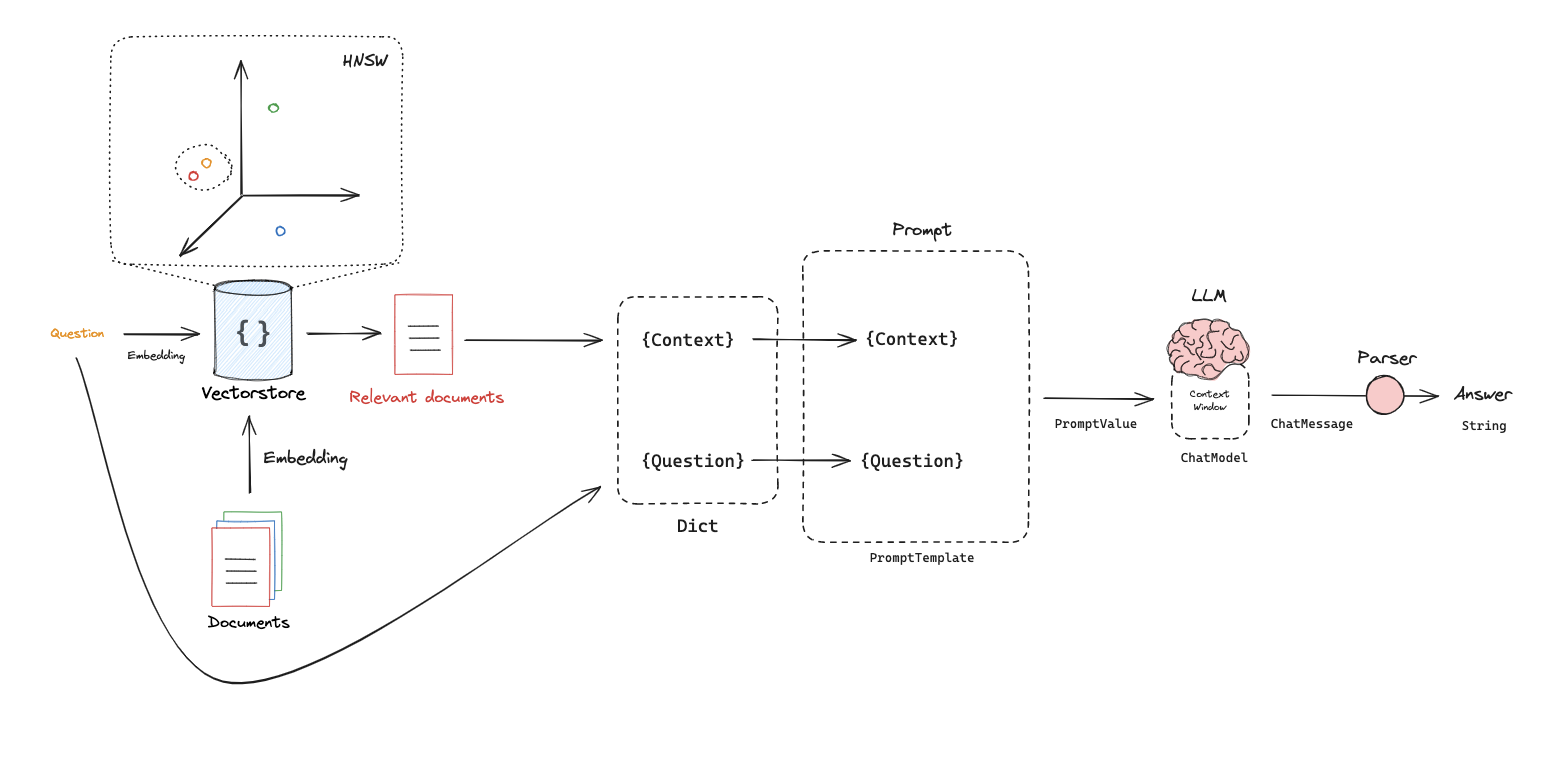

In [79]:
from langchain_groq import ChatGroq
from langchain.prompts import ChatPromptTemplate

#Prompt
template = """Answer the question based only on the context:
{context}
Question: {question}"""

prompt = ChatPromptTemplate.from_template(template)
prompt

ChatPromptTemplate(input_variables=['context', 'question'], messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], template='Answer the question based only on the context:\n{context}\nQuestion: {question}'))])

In [80]:
#llm
from langchain_core.output_parsers import StrOutputParser

load_dotenv()

key = os.getenv('GROQ_API_KEY')
parser = StrOutputParser()

Model = 'llama-3.1-8b-instant'
model = ChatGroq(api_key=key,model=Model )

chain = prompt | model | parser

chain.invoke({"context": docs, "question": "What is Task Decomposition?"})


'Task Decomposition is the process of breaking down complex tasks into smaller and simpler steps. This is necessary for an agent to plan ahead and understand what steps are involved in completing a task.'

In [81]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

rag_chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)

rag_chain.invoke("What is Task Decomposition?")

'Task decomposition is the process of breaking down a complicated task into multiple smaller and simpler steps. This is necessary for an agent to plan ahead and understand what steps are involved in completing the task.'

## QUERY TRANSFORMATIONS

![alt text](multi-query.png)

## MULTI QUERY